# RAG pipeline development

In [9]:
import json
import logging

import chromadb
import pandas as pd

from chromadb.config import Settings
from IPython.display import Image, display
from langchain_chroma import Chroma
from langchain_community.embeddings import GPT4AllEmbeddings
from langchain_community.llms.gpt4all import GPT4All
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

In [3]:
logging.basicConfig(level=logging.INFO)

pd.options.display.max_colwidth = 200

In [12]:
NEWLINE = "\n"

In [4]:
llm = GPT4All(
    model="Llama-3.2-1B-Instruct-Q4_0.gguf",
    allow_download=True,
    n_threads=8,
)

Failed to load libllamamodel-mainline-cuda.so: dlopen: libcudart.so.11.0: cannot open shared object file: No such file or directory
Failed to load libllamamodel-mainline-cuda-avxonly.so: dlopen: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [5]:
embeddings = GPT4AllEmbeddings(
    model_name="all-MiniLM-L6-v2.gguf2.f16.gguf",
    n_threads=8,
)

In [6]:
chroma_client = chromadb.PersistentClient(
    path="../data/database/wikipedia.db",
    settings=Settings(allow_reset=True),
)

INDEX_NAME = "wikipedia-index"
vector_store = Chroma(
    client=chroma_client,
    collection_name=INDEX_NAME,
    embedding_function=embeddings,
)

INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


In [7]:
vector_store._chroma_collection.count()

7873

## Building a RAG pipeline

In [49]:
prompt_template = """Answer the question based only on the retrieved documents.
Cite the source of the information in the format [source: doc1].
If the answer is not in the context, say "I don't know".

Retrieved documents::
{context}

Question: {question}

Answer: """

prompt = ChatPromptTemplate.from_template(prompt_template)

In [50]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


def retrieve(state: State):
    retrieved_docs = vector_store.search(
        state["question"],
        search_type="similarity",
        k=5,
    )
    logging.info(f"Retrieved {len(retrieved_docs)} documents")

    for i, doc in enumerate(retrieved_docs, start=1):
        logging.info(f"  Document {i}: {doc.metadata['title']}")
        logging.info(f"  Content: {doc.page_content[:100].replace(NEWLINE, '  ')}...")

    return {"context": retrieved_docs}


def generate(state: State):
    # docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    docs_content = {
        f"[doc{doc_id}]": {
            "title": doc.metadata["title"],
            "content": doc.page_content,
        }
        for doc_id, doc in enumerate(state["context"])
    }
    docs_content = json.dumps(docs_content, indent=2)

    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response}

In [51]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

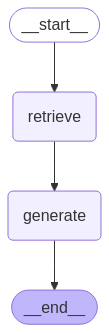

In [52]:
display(Image(graph.get_graph().draw_mermaid_png()))

## Query the RAG pipeline

In [53]:
articles_df = pd.read_parquet("../data/input/wikipedia_articles.parquet")

In [54]:
articles_df[["title", "summary"]].sample(5)

,title,summary
3895,X,"X, or x, is the twenty-fourth letter of the Latin alphabet, used in the modern English alphabet, the alphabets of other western European languages and others worldwide. Its name in English is ex (..."
308,ArmaLite AR-10,The ArmaLite AR-10 is a 7.62×51mm NATO battle rifle designed by Eugene Stoner in the late 1950s and manufactured by ArmaLite (then a division of the Fairchild Aircraft Corporation). When first int...
3716,Tarsus İdman Yurdu,Tarsus İdman Yurdu is a Turkish sports club based in Tarsus.
2282,List of Intel Core processors,"The following is a list of Intel Core processors. This includes Intel's original Core (Solo/Duo) mobile series based on the Enhanced Pentium M microarchitecture, as well as its Core 2- (Solo/Duo/Q..."
1982,KK Mega Basket,"Košarkaški klub Mega Basket (Serbian Cyrillic: Кошаркашки клуб Мега Баскет), currently referred to as Mega Superbet for sponsorship reasons, is a men's professional basketball club based in Belgra..."


In [56]:
result = graph.invoke(
    {"question": "what's a flush toilet? answer briefly"},
)
print()
print(result["answer"])

INFO:root:Retrieved 5 documents
INFO:root:  Document 1: Flush toilet
INFO:root:  Content: Flush toilet  Flush toilets are a type of plumbing fixture, and usually incorporate a bend called a t...
INFO:root:  Document 2: Flush toilet
INFO:root:  Content: Flush toilet  A flush toilet (also known as a flushing toilet, water closet (WC); see also toilet nam...
INFO:root:  Document 3: Toilet: Ek Prem Katha
INFO:root:  Content: Toilet: Ek Prem Katha  Up until then, the lack of infrastructure led to nearly half of the rural popu...
INFO:root:  Document 4: Toilet: Ek Prem Katha
INFO:root:  Content: Toilet: Ek Prem Katha  Toilet: Ek Prem Katha (transl. Toilet: A Love   Story) or simply Toilet, is a 2...
INFO:root:  Document 5: Toilet Duck
INFO:root:  Content: Toilet Duck  The "Toilet" moniker has been dropped from the name in the UK and Ireland, and the produ...



 A flush toilet (also known as a flushing toilet) is a type of plumbing fixture that disposes of human waste by collecting it in a bowl and then using water to channel it through a drainpipe to another location for treatment. [doc1]
